In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow

def unet(pretrained_weights = None,input_size = (192,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs=inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    #if(pretrained_weights):
    #	model.load_weights(pretrained_weights)

    return model


In [ ]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from PIL import Image
import pandas as pd
import glob

In [2]:
def fast_display(*img2dlist):
    plt.figure(figsize=(16,8))
    nbimg = len(img2dlist)
    cols = min (9,nbimg)
    rows = (nbimg // cols) +1
    for ii, img2d in enumerate(img2dlist):
        plt.subplot(rows,cols,1+ii)
        plt.imshow(img2d)
    plt.show()

In [ ]:
/home/marsu/Documents/epita/inria/MaskTheFace/visage-tonus-after.jpg

In [ ]:
/home/marsu/Documents/epita/inria/MaskTheFace/visage-tonus-after_N95.jpg

uint8
uint8
(520, 700, 3)
done


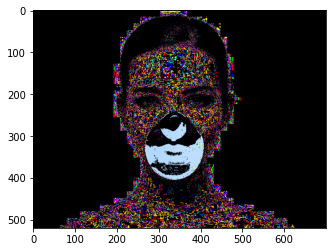

In [1]:
from matplotlib import image
from matplotlib import pyplot as plt 
import numpy as np
# load image as pixel array
image_withoutmask = np.copy(image.imread('/home/marsu/Documents/epita/inria/MaskTheFace/visage-tonus-after.jpg'))
image_masked = np.copy(image.imread('/home/marsu/Documents/epita/inria/MaskTheFace/visage-tonus-after_N95.jpg'))

# summarize shape of the pixel array

image_withoutmask.astype(np.intc)
image_masked.astype(np.intc)
print(image_withoutmask.dtype)
print(image_masked.dtype)
print(image_withoutmask.shape)
# display the array of pixels as an image
image_masked[image_masked == image_withoutmask] = 0
for i in range(len(image_masked)):
    for j in range(len(image_masked[0])):
        for c in range(3):
            
            tmp1 = image_masked[i,j].sum() 
            tmp2 = (image_withoutmask[i,j].sum())
            if tmp1 >= tmp2:
                tmp = tmp1 - tmp2
            else:
                tmp = tmp2 - tmp1
            if  tmp < 100:
                image_masked[i,j] = [0,0,0]
            #print(tmp)
            #else:
            #    print(image_masked[i,j], image_withoutmask[i,j])
print('done')
plt.imshow(image_masked)
plt.show()

(625, 625)
(625, 625)
(625, 625)


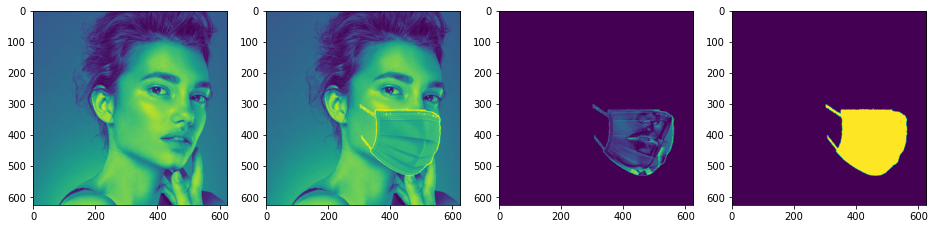

In [33]:
from skimage import color
from skimage import io
from skimage.util import compare_images
from scipy.ndimage.morphology import binary_fill_holes
#img =(io.imread('image.png'))
image_withoutmask =  color.rgb2gray(image.imread('/home/marsu/Documents/epita/inria/MaskTheFace/visage2.jpg'))
image_masked =  color.rgb2gray(image.imread('/home/marsu/Documents/epita/inria/MaskTheFace/visage2_surgical.jpg'))
diff_rotated = compare_images(image_withoutmask, image_masked, method='diff')
diff_rotated[diff_rotated < 0.05] = 0
#diff_rotated[diff_rotated != 0] = 1

b = binary_fill_holes(diff_rotated)
print(image_withoutmask.shape)
print(image_masked.shape)
a = image_masked == image_withoutmask
print(a.shape)
fast_display(image_withoutmask,image_masked,diff_rotated,b)
